# Imports and settings

In [19]:
### Do the imports -- no need to change this
import numpy as np
from typing import List
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import sys

In [20]:
import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 10)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
torch.manual_seed(0)

import base64, io

# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
from utils.classes import Policy

import utils.classes
torch.serialization.add_safe_globals([getattr, torch.nn.modules.linear.Linear, utils.classes.Policy])

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
torch.manual_seed(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

'''
class Policy(nn.Module): # define the policy network
    def __init__(self, state_size=4, action_size=2, hidden_size=32):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, action_size)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = self.fc2(x)
        return F.softmax(x, dim=1) # we just consider 1 dimensional probability of action

    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        model = Categorical(probs)
        action = model.sample()
        return action.item(), model.log_prob(action)
    
    def get_prob(self, state, action):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        return probs[0, action]
'''


# Testing baselines for REINFORCE

# Generating the preference dataset

In [ ]:
from utils.generate_preference_dataset import generate_trajectories
from utils.baselines import naive_baseline
from utils.reinforce import reinforce_rwd2go_baseline

In [ ]:
# Policy saving

np.bool8 = bool
seed = 0
env = gym.make('CartPole-v1')
env.reset(seed=seed)
target_score = 10
n_episodes = 100
print_every = 100
max_t = 1000
baseline = naive_baseline

example_policy = Policy().to(device)
optimizer_baseline_1 = optim.Adam(example_policy.parameters(), lr=1e-2)
example_scores = reinforce_rwd2go_baseline(example_policy, optimizer_baseline_1, seed=seed, env=env, target_score=target_score, baseline=baseline, early_stop=False, n_episodes=n_episodes, max_t=max_t, print_every=print_every, save_models_every=False)

Episode 0	Average Score: 27.00
Episode 0	Current Score: 27.00
Episode 0	Current Score: 27.00
Episode 1	Current Score: 11.00
Episode 3	Current Score: 29.00
Episode 6	Current Score: 10.00
Episode 11	Current Score: 10.00
Episode 12	Current Score: 10.00
Episode 15	Current Score: 11.00
Episode 21	Current Score: 59.00
Episode 25	Current Score: 60.00
Episode 50	Current Score: 67.00
Episode 54	Current Score: 94.00
Episode 72	Current Score: 108.00
Episode 86	Current Score: 109.00
Episode 91	Current Score: 128.00
Episode 100	Average Score: 43.52
Episode 100	Current Score: 82.00


# Loading policies (manual intervention required)

In [28]:
PATH = os.path.abspath(os.getcwd())

# TO COMPLETE, choose the file names of the desired policies

pi1_path = os.path.join(PATH, 'saved_policies', 'model_91.pt')

pi2_path = os.path.join(PATH, 'saved_policies', 'model_11.pt')

In [ ]:
# Generate preference dataset

K_pairs = [15, 50, 100, 200, 300]
for k in enumerate(K_pairs):
    pref_dataset_size = k
    pi1 = Policy().to(device)
    pi1.load_state_dict(torch.load(pi1_path, weights_only=True))

    env = gym.make('CartPole-v1')
    env.reset(seed=seed)
    trajectories_rewards_pi1, trajectories_states_pi1, trajectories_actions_pi1 = generate_trajectories(pi1, pref_dataset_size, env=env, max_t=1000, seed = seed, dim_state=4)

    pi2 = Policy().to(device)
    pi2.load_state_dict(torch.load(pi2_path, weights_only=True))
    
    env = gym.make('CartPole-v1')
    trajectories_rewards_pi2, trajectories_states_pi2, trajectories_actions_pi2 = generate_trajectories(pi2, pref_dataset_size, env=env, max_t=1000, seed = seed, dim_state=4)



Trajectory:  0
Trajectory:  10
Trajectory:  20
Trajectory:  30
Trajectory:  40
Trajectory:  50
Trajectory:  60
Trajectory:  70
Trajectory:  80
Trajectory:  90
Trajectory:  100
Trajectory:  110
Trajectory:  120
Trajectory:  130
Trajectory:  140
Trajectory:  150
Trajectory:  160
Trajectory:  170
Trajectory:  180
Trajectory:  190
Trajectory:  0
Trajectory:  10
Trajectory:  20
Trajectory:  30
Trajectory:  40
Trajectory:  50
Trajectory:  60
Trajectory:  70
Trajectory:  80
Trajectory:  90
Trajectory:  100
Trajectory:  110
Trajectory:  120
Trajectory:  130
Trajectory:  140
Trajectory:  150
Trajectory:  160
Trajectory:  170
Trajectory:  180
Trajectory:  190


In [30]:
avg_pi1 = np.mean(trajectories_rewards_pi1)
avg_pi2 = np.mean(trajectories_rewards_pi2)
print(avg_pi1, avg_pi2)

99.18 17.38


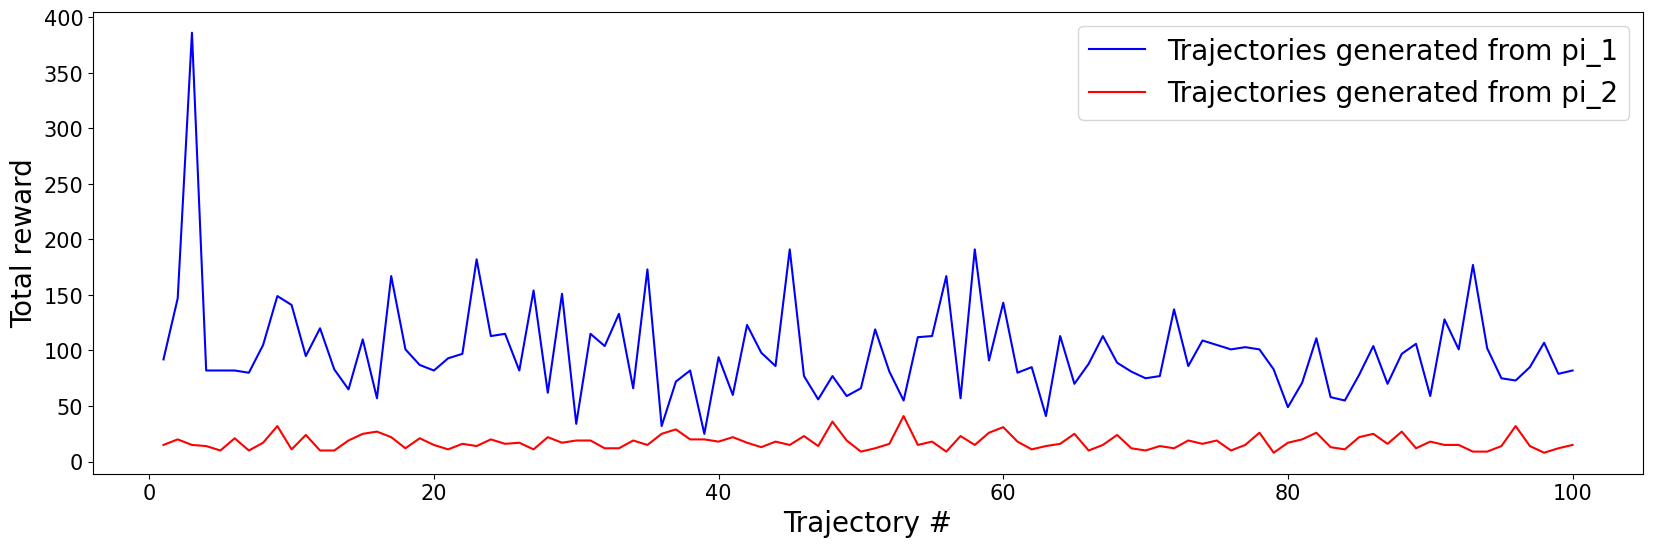

In [31]:
### Plot the learning progress

# Create the plot
fig = plt.figure(figsize=(20, 6))
ax = fig.add_subplot(111)

# Plot the scores with specified colors and labels
#ax.plot(np.arange(1, len(scores_rwd2go) + 1), scores_rwd2go, color='green', label='No Baseline')
ax.plot(np.arange(1, len(trajectories_rewards_pi1) + 1), trajectories_rewards_pi1, color='blue', label='Trajectories generated from pi_1')
ax.plot(np.arange(1, len(trajectories_rewards_pi2) + 1), trajectories_rewards_pi2, color='red', label='Trajectories generated from pi_2')

# Set the labels with a larger font size
ax.set_ylabel('Total reward', fontsize=20)
ax.set_xlabel('Trajectory #', fontsize=20)

# Set the tick labels to a larger font size
ax.tick_params(axis='both', which='major', labelsize=15)

# Add a legend with a specified font size
ax.legend(fontsize=20)

# Show the plot
plt.show()

In [75]:
SEEDS = [42, 123, 456]
TOTAL_TIMESTEPS = 50000
ENV_NAME = ['CartPole-v1', 'MountainCar-v0']
EVAL_N_EPISODES = 5
EVAL_LEARNING_RATE = 0.005

### DPO

In [73]:
# DPO algorithm
import torch

def build_preference_dataset(preferred_states, preferred_actions, rejected_states, rejected_actions):
    """
    For each state in preferred_states, find the same state in rejected_states.
    If found, add (state, preferred_action, rejected_action) to the dataset.
    """
    pref_data = []
    for i, s_pref in enumerate(preferred_states):
        if s_pref.all() == 0:
            continue
        for j, s_rej in enumerate(rejected_states):
            if np.allclose(s_pref, s_rej, atol=1e-5):  # Use a tolerance for float comparison
                pref_data.append((s_pref, int(preferred_actions[i]), int(rejected_actions[j])))
                break  # Stop after finding the first match
    return pref_data

def dpo_loss(pref_dataset, policy, beta=1.0):
    loss = 0
    for s_tensor, a_plus, a_minus in pref_dataset:
        #s_tensor = torch.tensor(s, dtype=torch.float32).unsqueeze(0)
        log_pi_plus = torch.log(policy.get_prob(s_tensor, a_plus))
        log_pi_minus = torch.log(policy.get_prob(s_tensor, a_minus))
        
        diff = beta * (log_pi_plus - log_pi_minus)
        loss += -torch.log(torch.sigmoid(diff))
    return loss / len(pref_dataset)# main DPO


In [78]:
# Generate preference dataset
rewards_per_seed = []
for seed in SEEDS:
    K_pairs = [15, 50, 100, 200, 300]
    rewards_K_pairs = []
    for k in K_pairs:
        pref_dataset_size = k
        pi1 = Policy().to(device)
        pi1.load_state_dict(torch.load(pi1_path, weights_only=True))

        env = gym.make(ENV_NAME[0])
        env.reset(seed=seed)
        trajectories_rewards_pi1, trajectories_states_pi1, trajectories_actions_pi1 = generate_trajectories(pi1, pref_dataset_size, env=env, max_t=1000, seed = seed, dim_state=4)

        pi2 = Policy().to(device)
        pi2.load_state_dict(torch.load(pi2_path, weights_only=True))
        
        env = gym.make(ENV_NAME[0])
        env.reset(seed=seed)
        trajectories_rewards_pi2, trajectories_states_pi2, trajectories_actions_pi2 = generate_trajectories(pi2, pref_dataset_size, env=env, max_t=1000, seed = seed, dim_state=4)

        pref_dataset = []
        for traj1_states, traj2_states, traj1_actions, traj2_actions, rew1, rew2 in zip(trajectories_states_pi1, trajectories_states_pi2, trajectories_actions_pi1, trajectories_actions_pi2, trajectories_rewards_pi1, trajectories_rewards_pi2):
            prob_pref_traj1 = np.exp(rew1) / (np.exp(rew1) + np.exp(rew2))
            if np.random.rand() < prob_pref_traj1:
                preferred_states, preferred_actions = traj1_states, traj1_actions
                rejected_states, rejected_actions = traj2_states, traj2_actions
            else:
                preferred_states, preferred_actions = traj2_states, traj2_actions
                rejected_states, rejected_actions = traj1_states, traj1_actions

            dataset = build_preference_dataset(preferred_states, preferred_actions, rejected_states, rejected_actions)
            pref_dataset.extend(dataset)

        policy = Policy().to(device)
        optimizer = optim.Adam(policy.parameters(), lr=0.05)  # Reduced learning rate for stability
        beta = 1.0 


        for epoch in range(100):  # Train for 100 epochs
            loss = dpo_loss(pref_dataset, policy, beta)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            print(f"Epoch {epoch + 1}, Loss: {loss.item()}")

        policy.eval()

        trajectories_rewards_pi1, trajectories_states_pi1, trajectories_actions_pi1 = generate_trajectories(policy, k, env=env, max_t=1000, seed = seed, dim_state=4)

        avg_pi1 = np.mean(trajectories_rewards_pi1)
        rewards_K_pairs.append(avg_pi1)

    rewards_per_seed.append(rewards_K_pairs)

# results
tot_reward_per_k_pairs = np.mean(rewards_per_seed, axis=0)

Trajectory:  0
Trajectory:  10
Trajectory:  0
Trajectory:  10
Epoch 1, Loss: 0.6748761534690857
Epoch 2, Loss: 0.6494290232658386
Epoch 3, Loss: 0.6527189612388611
Epoch 4, Loss: 0.6437044739723206
Epoch 5, Loss: 0.6321012377738953
Epoch 6, Loss: 0.6258981227874756
Epoch 7, Loss: 0.622244656085968
Epoch 8, Loss: 0.6173526644706726
Epoch 9, Loss: 0.6113287210464478
Epoch 10, Loss: 0.60708087682724
Epoch 11, Loss: 0.6063920259475708
Epoch 12, Loss: 0.6074334979057312
Epoch 13, Loss: 0.6080721020698547
Epoch 14, Loss: 0.608634889125824
Epoch 15, Loss: 0.6095234751701355
Epoch 16, Loss: 0.6099302768707275
Epoch 17, Loss: 0.6086252331733704
Epoch 18, Loss: 0.6066303849220276
Epoch 19, Loss: 0.6053695678710938
Epoch 20, Loss: 0.6046792268753052
Epoch 21, Loss: 0.604231595993042
Epoch 22, Loss: 0.6039504408836365
Epoch 23, Loss: 0.6039759516716003
Epoch 24, Loss: 0.6042301058769226
Epoch 25, Loss: 0.6044011116027832
Epoch 26, Loss: 0.6044076085090637
Epoch 27, Loss: 0.6043234467506409
Epoch 2

(array([-0.00303268, -0.00523447, -0.03759432,  0.025485  ]), 1, 0)


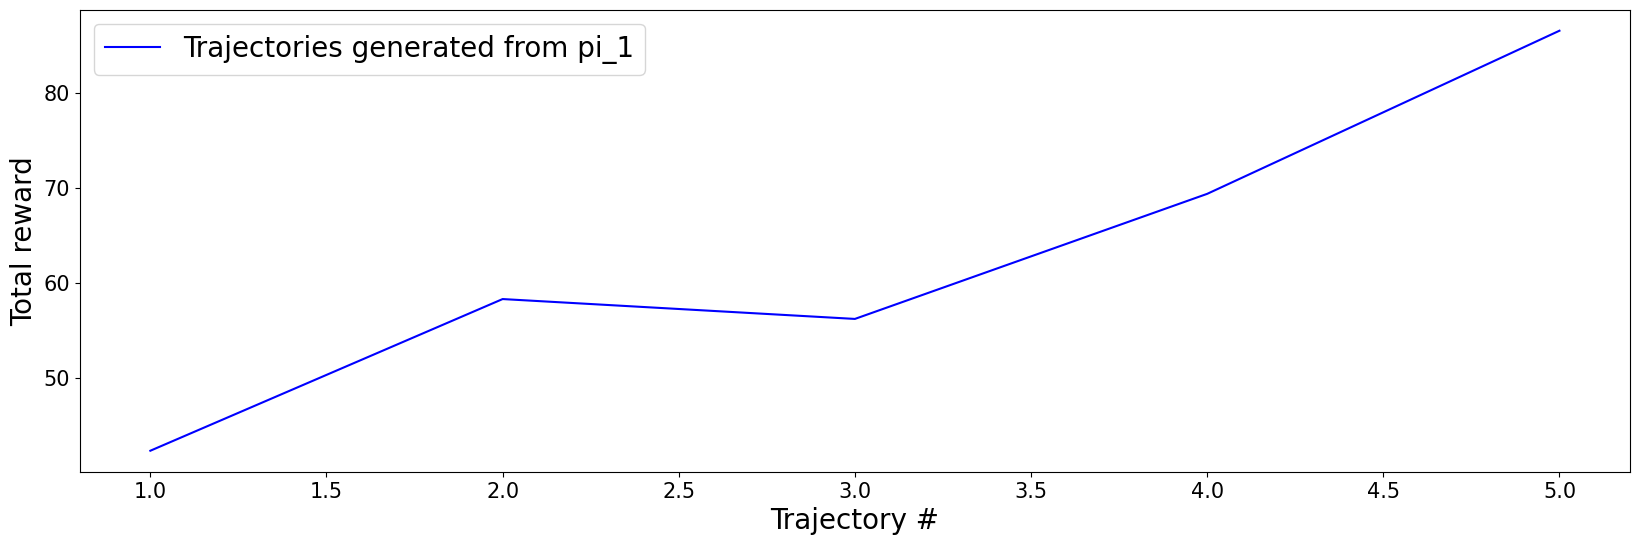

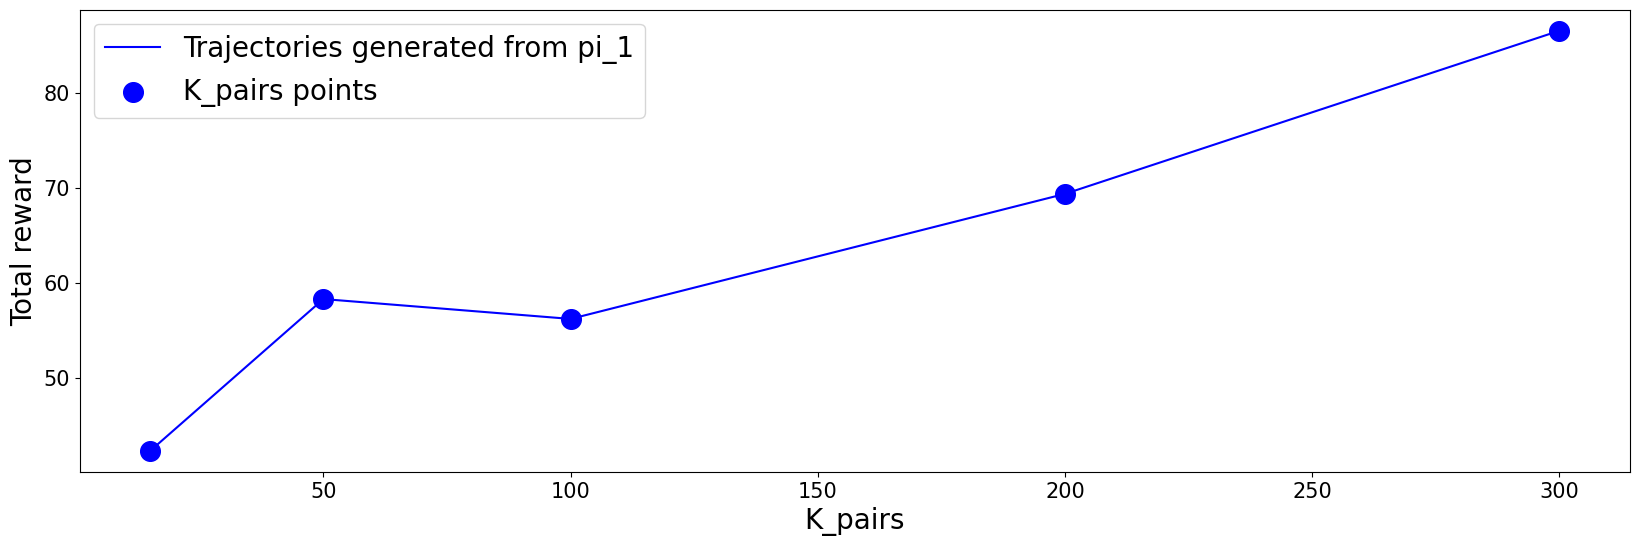

In [ ]:
print(pref_dataset[0][:5])

# Plot the results
K_pairs = [15, 50, 100, 200, 300]  # Make sure this matches your experiment

fig = plt.figure(figsize=(20, 6))
ax = fig.add_subplot(111)

# Plot the line
ax.plot(K_pairs, tot_reward_per_k_pairs, color='blue', label='Trajectories generated from pi_1')

# Add big scatter points
ax.scatter(K_pairs, tot_reward_per_k_pairs, color='blue', s=200, zorder=5, label='K_pairs points')

# Set the labels with a larger font size
ax.set_ylabel('Total reward', fontsize=20)
ax.set_xlabel('K_pairs', fontsize=20)

# Set the tick labels to a larger font size
ax.tick_params(axis='both', which='major', labelsize=15)

# Add a legend with a specified font size
ax.legend(fontsize=20)

# Show the plot
plt.show()


In [ ]:
# ...existing code...

K_pairs = [15, 50, 100, 200, 300]  # Make sure this matches your experiment

fig = plt.figure(figsize=(20, 6))
ax = fig.add_subplot(111)

# Plot the line
ax.plot(K_pairs, tot_reward_per_k_pairs, color='blue', label='Trajectories generated from pi_1')

# Add big scatter points
ax.scatter(K_pairs, tot_reward_per_k_pairs, color='blue', s=200, zorder=5, label='K_pairs points')

# Set the labels with a larger font size
ax.set_ylabel('Total reward', fontsize=20)
ax.set_xlabel('K_pairs', fontsize=20)

# Set the tick labels to a larger font size
ax.tick_params(axis='both', which='major', labelsize=15)

# Add a legend with a specified font size
ax.legend(fontsize=20)

# Show the plot
plt.show()
# ...existing code...

In [80]:
# main DPO
# Train DPO

policy = Policy().to(device)
optimizer = optim.Adam(policy.parameters(), lr=0.1)
beta = 1.0 


for epoch in range(100):  # Train for 100 epochs
    loss = dpo_loss(pref_dataset, policy, beta)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch + 1}, Loss: {loss.item()}")
    

Epoch 1, Loss: 0.7086021900177002
Epoch 2, Loss: 0.7377104759216309
Epoch 3, Loss: 0.6784712076187134
Epoch 4, Loss: 0.6594825983047485
Epoch 5, Loss: 0.6685381531715393
Epoch 6, Loss: 0.6611574292182922
Epoch 7, Loss: 0.6512119770050049
Epoch 8, Loss: 0.6541631817817688
Epoch 9, Loss: 0.6595650911331177
Epoch 10, Loss: 0.6574446558952332
Epoch 11, Loss: 0.6520212292671204
Epoch 12, Loss: 0.649188220500946
Epoch 13, Loss: 0.650086522102356
Epoch 14, Loss: 0.6511397957801819
Epoch 15, Loss: 0.6500719785690308
Epoch 16, Loss: 0.6479367613792419
Epoch 17, Loss: 0.6470823884010315
Epoch 18, Loss: 0.6479200720787048
Epoch 19, Loss: 0.6483457684516907
Epoch 20, Loss: 0.6475061178207397
Epoch 21, Loss: 0.6467530131340027
Epoch 22, Loss: 0.6469113230705261
Epoch 23, Loss: 0.6469954252243042
Epoch 24, Loss: 0.6463541984558105
Epoch 25, Loss: 0.645878255367279
Epoch 26, Loss: 0.6462613940238953
Epoch 27, Loss: 0.6465274095535278
Epoch 28, Loss: 0.6460448503494263
Epoch 29, Loss: 0.64571166038513

Trajectory:  0
Trajectory:  10
Trajectory:  20
Trajectory:  30
Trajectory:  40
Trajectory:  50
Trajectory:  60
Trajectory:  70
Trajectory:  80
Trajectory:  90
Trajectory:  100
Trajectory:  110
Trajectory:  120
Trajectory:  130
Trajectory:  140
Trajectory:  150
Trajectory:  160
Trajectory:  170
Trajectory:  180
Trajectory:  190


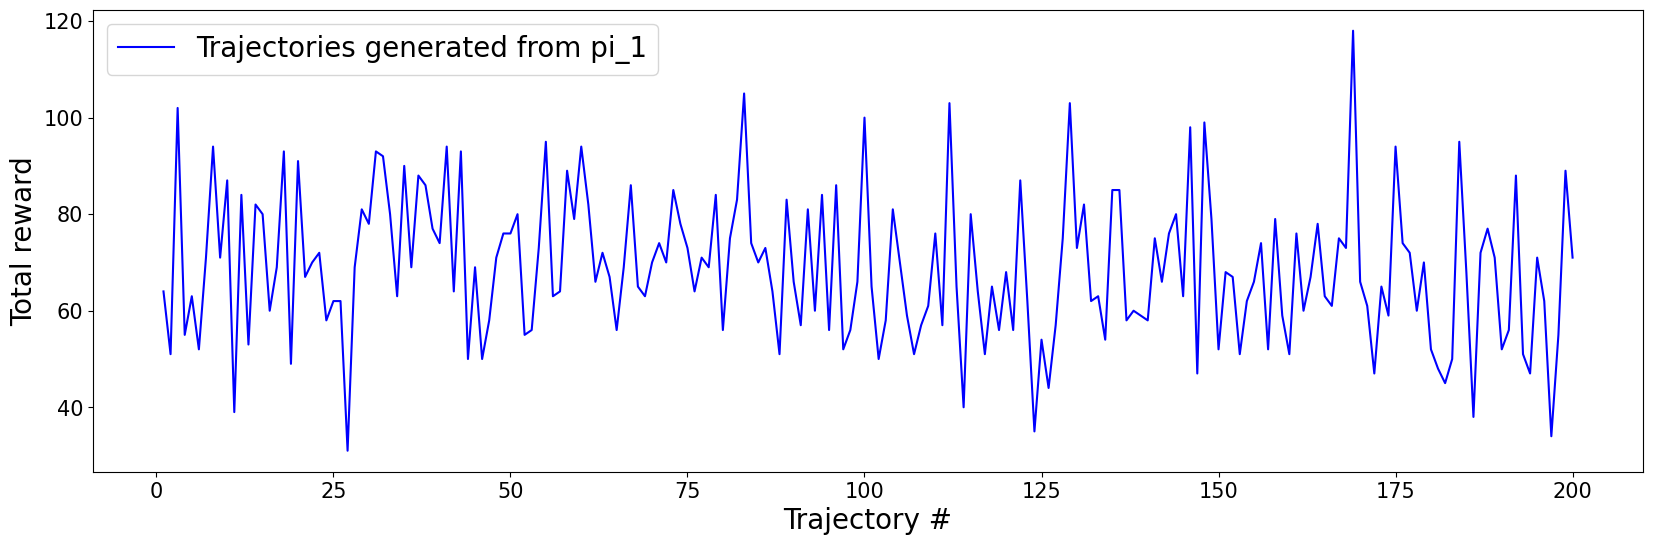

68.835


In [72]:
env = gym.make('CartPole-v1')
env.reset(seed=0)
# Test the policy
policy.eval()

trajectories_rewards_pi1, trajectories_states_pi1, trajectories_actions_pi1 = generate_trajectories(policy, 200, env=env, max_t=1000, seed = 0, dim_state=4)
### Plot the learning progress

# Create the plot
fig = plt.figure(figsize=(20, 6))
ax = fig.add_subplot(111)

# Plot the scores with specified colors and labels
#ax.plot(np.arange(1, len(scores_rwd2go) + 1), scores_rwd2go, color='green', label='No Baseline')
ax.plot(np.arange(1, len(trajectories_rewards_pi1) + 1), trajectories_rewards_pi1, color='blue', label='Trajectories generated from pi_1')

# Set the labels with a larger font size
ax.set_ylabel('Total reward', fontsize=20)
ax.set_xlabel('Trajectory #', fontsize=20)

# Set the tick labels to a larger font size
ax.tick_params(axis='both', which='major', labelsize=15)

# Add a legend with a specified font size
ax.legend(fontsize=20)

# Show the plot
plt.show()

avg_pi1 = np.mean(trajectories_rewards_pi1)
print(avg_pi1)